# **WiDS Datathon 2020 Challenge** 
Problem Overview:

The challenge is to create a model that uses data from the first 24 hours of intensive care to predict patient survival. MIT's GOSSIS community initiative, with privacy certification from the Harvard Privacy Lab as acceptable for use in the WiDS Datathon, has provided a dataset of more than 130,000 hospital Intensive Care Unit (ICU) visits from patients, spanning a one-year timeframe. This data is part of a growing global effort and consortium spanning Argentina, Australia, New Zealand, Sri Lanka, Brazil, and more than 200 hospitals in the United States.

The datathon task is to train a model that takes as input the patient record data and outputs a prediction of how likely it is that the patient survives. Labeled training and test datasets are provided for model development; you will then upload your predictions for an unlabeled test set to Kaggle and these predictions will be used to determine the public leaderboard rankings, and the final winners of the competition. Data analysis can be done using your preferred tools. The winners will be determined by the leaderboard on the Kaggle platform at the time the contest closes February 24 2020

Link for the Kaggle website: https://www.kaggle.com/c/widsdatathon2020/overview




Author: Vincent Lee

Date: 02/24/2019


## Import libraries

In [1]:
# import packages
import warnings
warnings.filterwarnings("ignore")

# data prep and EDA
import numpy as np
import pandas as pd
import scipy
import scipy.stats as st
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# parameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# algorithms
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ensemble methods
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

# model evaluation
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Exploratory Data Analysis (EDA) 
File descriptions
1. training.csv - the training set
2. unlabeled.csv - the data set without hospital_death provided ( Column D- empty)
3. samplesubmission.csv - a sample submission file in the correct format
4. solution_template.csv - a list of all the rows (and encounters) that should be in your submissions
5. WiDS Datathon 2020 Dictionary.csv - supplemental information about the data

## Import data

In [2]:
datapath= 'C:/Users/vincentlee/Desktop/datascienceprojects/Kaggle/widsdatathon2020'

In [11]:
training_df_cleaned = pd.read_csv(datapath+'/training.csv')
test_df = pd.read_csv(datapath+'/unlabeled.csv')


## Reduce data frame memory

In [3]:
## Reducing memory function (to reduce the DF size)
def reduce_memory(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return end_mem
  # run reduce memory outside of function

In [20]:
reduce_memory(training_df)
reduce_memory(test_df)

Mem. usage decreased to 36.74 Mb (0.0% reduction)
Mem. usage decreased to 16.01 Mb (71.3% reduction)


16.007083892822266

## Check missing values in training dataset

In [4]:
#function to do missing value computation
def cal_missing_val(df):
    data_dict = {}
    for col in df.columns:
        data_dict[col] = df[col].isnull().sum()/df.shape[0]*100
    return pd.DataFrame.from_dict(data_dict, orient='index', columns=['MissingValue'])

In [22]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float16(170), int16(2), int32(2), int8(4), object(8)
memory usage: 36.7+ MB


### Calculating missing values for demographic variables

In [23]:
demographicvariables = ["hospital_death","age","bmi","elective_surgery",
                        "ethnicity","gender","height","hospital_admit_source",
                        "icu_admit_source","icu_id","icu_stay_type",
                        "icu_type","pre_icu_los_days","readmission_status","weight"]

cal_missing_val(training_df_cleaned[demographicvariables]).sort_values(by=['MissingValue'],ascending=False)

,MissingValue
hospital_admit_source,23.343474
age,4.610033
bmi,3.738837
weight,2.965774
ethnicity,1.521049
height,1.454538
icu_admit_source,0.122120
gender,0.027259
hospital_death,0.000000
elective_surgery,0.000000


### Calculating missing values for labs and vitals variables

In [24]:
lab_1 = [col for col in training_df_cleaned.columns if 'd1_' in col]
lab_2 = [col for col in training_df_cleaned.columns if 'h1_' in col]
labvitalvariables = lab_1+lab_2
len(labvitalvariables)

128

In [25]:
missing_data = cal_missing_val(training_df_cleaned[labvitalvariables]).sort_values(by=['MissingValue'],
                                                                             ascending=False)

# hightlight missing values less than 50%
labvitals_selected = list(missing_data[missing_data['MissingValue'] < 50].index)
labvitals_selected

['h1_temp_max',
 'h1_temp_min',
 'd1_hco3_min',
 'd1_hco3_max',
 'd1_platelets_min',
 'd1_platelets_max',
 'd1_wbc_min',
 'd1_wbc_max',
 'd1_calcium_min',
 'd1_calcium_max',
 'd1_hemaglobin_max',
 'd1_hemaglobin_min',
 'd1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_bun_max',
 'd1_bun_min',
 'd1_sodium_max',
 'd1_sodium_min',
 'd1_creatinine_max',
 'd1_creatinine_min',
 'd1_potassium_min',
 'd1_potassium_max',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_diasbp_noninvasive_min',
 'h1_diasbp_noninvasive_max',
 'h1_sysbp_noninvasive_max',
 'h1_sysbp_noninvasive_min',
 'd1_glucose_max',
 'd1_glucose_min',
 'h1_mbp_min',
 'h1_mbp_max',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_min',
 'h1_spo2_max',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_sysbp_min',
 'h1_sysbp_max',
 'h1_heartrate_min',
 'h1_heartrate_max',
 'd1_temp_max',
 'd1_temp_min',
 'd1_mbp_noninvasive_min',
 'd1_mbp_noninvasive_max',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_sysbp_nonin

### Calculating missing values for apache variables

In [14]:
apachevariables = ['albumin_apache','apache_2_diagnosis','apache_3j_diagnosis',
                  'apache_post_operative', 'arf_apache', 'bilirubin_apache','bun_apache',
                   'creatinine_apache','fio2_apache','gcs_eyes_apache','gcs_motor_apache',
                   'gcs_unable_apache','gcs_verbal_apache','glucose_apache','heart_rate_apache',\
                   'hematocrit_apache','intubated_apache','map_apache','paco2_apache',
                   'paco2_for_ph_apache','pao2_apache','ph_apache','resprate_apache',
                   'sodium_apache','temp_apache','urineoutput_apache','ventilated_apache',
                   'wbc_apache','apache_4a_hospital_death_prob','apache_4a_icu_death_prob',
                   'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression',
                   'leukemia','lymphoma','solid_tumor_with_metastasis','apache_3j_bodysystem',
                   'apache_2_bodysystem','hospital_death']

cal_missing_val(training_df_cleaned[apachevariables]).sort_values(by=['MissingValue'],ascending=False)

,MissingValue
pao2_apache,77.271488
fio2_apache,77.271488
ph_apache,77.271488
paco2_for_ph_apache,77.271488
paco2_apache,77.271488
bilirubin_apache,63.386870
albumin_apache,59.292576
urineoutput_apache,53.425360
wbc_apache,24.000960
hematocrit_apache,21.674136


## Understand relationship/correlation between variables

In [16]:
# get absolute value of the correlation matrix
# method for correlation used here is spearman since there are categorical and numerical vriables
corr_matrix= (training_df_cleaned.corr(method="spearman").abs())

# due to symmetrical marix, we generate a triangle side of correlation matrix (upper) without diagonal (k=1)
corr_values = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))).stack()

# Sort the correlation values by highest to lowest
corr_values = (corr_values.sort_values(ascending=False))

In [18]:
# print out top 200 correlation values
corr_values[corr_values > 0.7]

paco2_apache          paco2_for_ph_apache     1.000000
d1_inr_min            h1_inr_min              1.000000
d1_inr_max            h1_inr_max              1.000000
h1_albumin_max        h1_albumin_min          0.999715
h1_bun_max            h1_bun_min              0.999545
                                                ...   
d1_arterial_pco2_min  h1_arterial_pco2_max    0.704404
heart_rate_apache     h1_heartrate_min        0.702930
d1_creatinine_min     h1_bun_max              0.701885
                      h1_bun_min              0.701682
h1_mbp_invasive_max   h1_mbp_max              0.701598
Length: 272, dtype: float64

### Correlation among demographic variables and hospital death

Most variables are not highly correlated except for weight, height and BMI. Weight has a higher correlation with BMI as compared to height. Since BMI is defined by weight and height, I will remove BMI from the variables

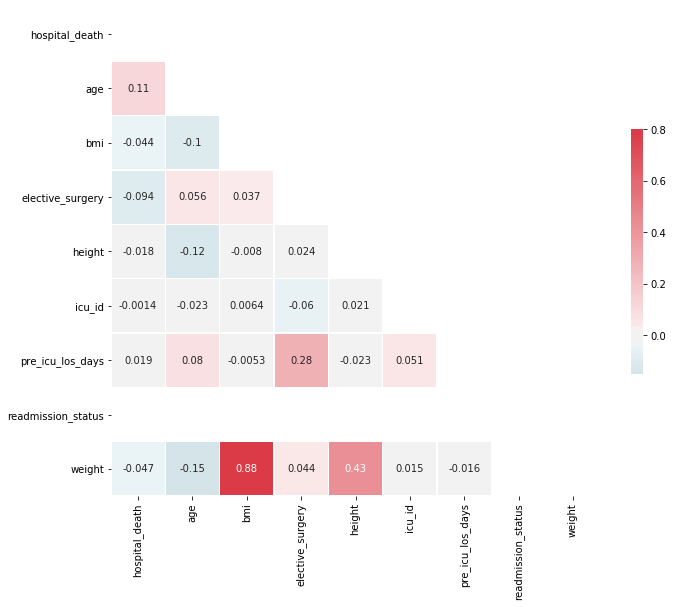

In [0]:
corr = training_df_cleaned[demographicvariables].corr(method="spearman")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Correlation among lab and vitals variables

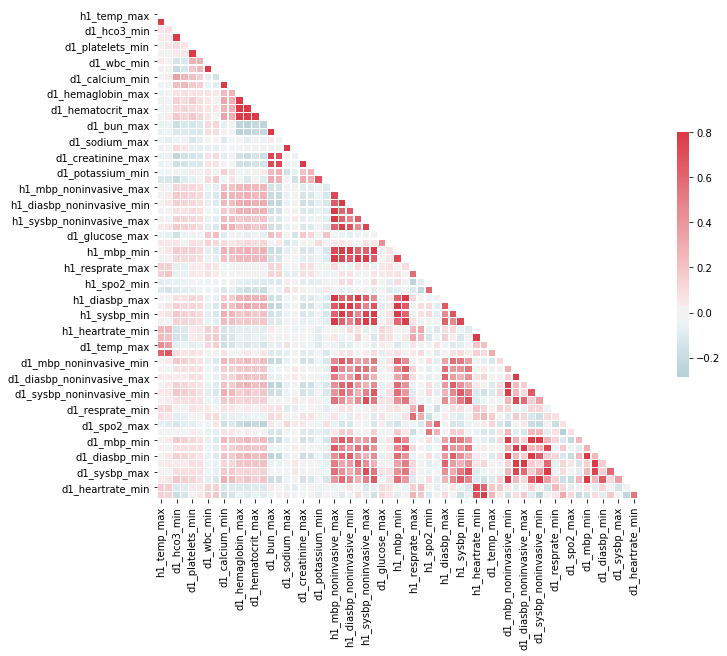

In [31]:
corr = training_df_cleaned[labvitals_selected].corr(method="spearman")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There are high correlations between h1 (hour 1) and d1 (day 1) among the following variables:
* mbp_noninvasive
* diasbp_noninvasive
* sysbp_noninvasive

### Correlation among apache variables

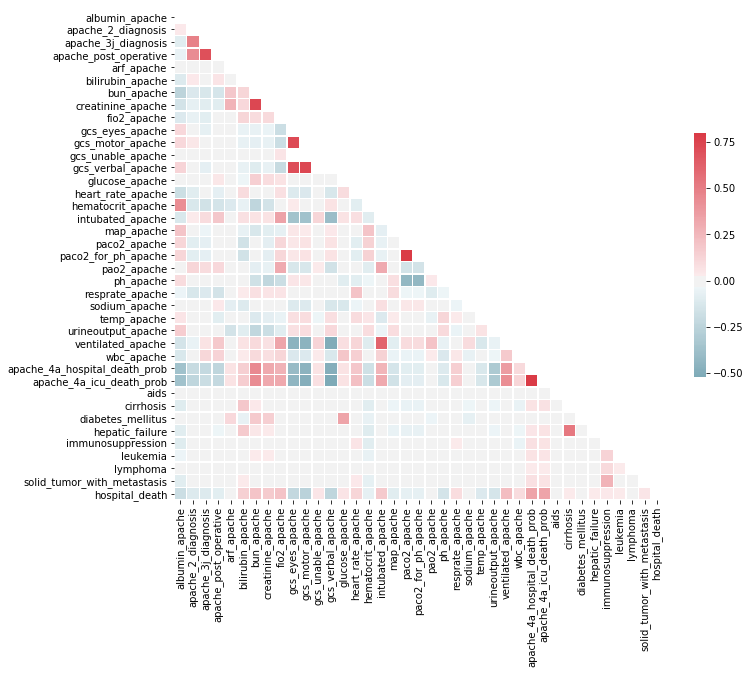

In [34]:
corr = training_df_cleaned[apachevariables].corr(method="spearman")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Observations from the correlations of apache variables:

1. Apache_post_operative has high correlation than Apache_2_diagnosis and 3j_diagnosis. Seems Apache_post_operative variables is a binary status: 1 for post-operative and 0 for non-operative and apache_2 and 3j are just diagonosis codes and seems like when apache 3j code is above 1000, it means post-operative. So, we can just drop apache 2 and 3j diagnosis and keep apache_post_operative variable  

2. gcs_verbal_apache is highly correlated with gcs_eyes and gcs_motor apache variables

3. paco2_for_ph_apache is highly correlated with paco2_apache

4. apache_4a_icu_death_probability is highly correlated with apache_4a_hospital_death_probability

In [35]:
training_df_cleaned[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','hospital_death']].corr(method="spearman")

,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,hospital_death
apache_4a_hospital_death_prob,1.000000,0.943293,0.335144
apache_4a_icu_death_prob,0.943293,1.000000,0.335855
hospital_death,0.335144,0.335855,1.000000


In [37]:
training_df_cleaned[['apache_4a_icu_death_prob','icu_type','apache_2_bodysystem','apache_post_operative']].corr(method="spearman")

,apache_4a_icu_death_prob,apache_post_operative
apache_4a_icu_death_prob,1.000000,-0.215757
apache_post_operative,-0.215757,1.000000


Since apache 4a hospital death probability correlates with icu death probability and icu death probability has higher correlation with hospital death than hospital death probability, we can just keep icu death probability.

## Visualizing data

In the training dataset, 8.63% died in the hospital and 91.3% of patients survived.

In [0]:
# separate training data by hospital death =1 and hospital death = 0 

death_df = training_df_cleaned[training_df_cleaned['hospital_death'] == 1]
survived_df = training_df_cleaned[training_df_cleaned['hospital_death'] == 0]
print (death_df.shape)
print (survived_df.shape)

(7915, 186)
(83798, 186)


### Understanding demographics of death and survived patients

### Summary observations from demographic variables 
1. Patients aged above 60 have a higher risk of death
2. Gender does not seem to have any significant effect on survivability.
3. This dataset have more cases on Caucasian than other races, which relates the general population. But Hispanic has a highest ratio of deaths over survival.
4. Risk of death is higher for BMI lower than 25
5. Patients weighed from 80kg to 150kg seem to have a higher chance of survival.
6. Patients who have total 5 or more days in the length of stay between hospital admission and unit admission have a higher risk of death. 
7. The highest number of survivals and deaths are on Medical Surgery ICU in this dataset. But highest ratio of death over survival is MICU followed by Cardiac ICU.

**Relationship between age and survivability**

The histogram plot below shows that patients below 60 have a higher chance of survial as compared to patients above 60. This could be an important feature to survivability but we have to analyze other features to get a clearer picture.

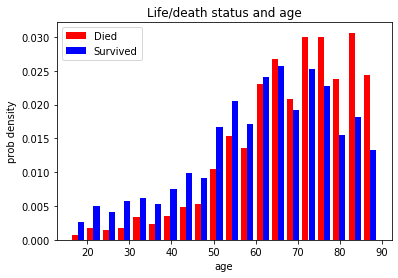

In [0]:
plt.hist([death_df['age'],survived_df['age']],bins=20,density=True,
         label=['Died','Survived'],color=['red','blue'])
plt.title("Life/death status and age")
plt.xlabel('age')
plt.ylabel('prob density')
plt.legend(loc='upper left')

The relationship between age and hospital death could not be explained by correlation because hospital death is a binary variable and also there is a monotonic relationship for age below 60 and countermonotonic relationship for age above 60

In [0]:
training_df_cleaned[['age','hospital_death']].corr(method="spearman").abs()

,age,hospital_death
age,1.000000,0.113611
hospital_death,0.113611,1.000000


**Relationship between Gender and survivability**

Gender does not seem to have any significant effect on survivability.

Male ratio of death over alive: 0.09219967765438368
Female ratio of death over alive: 0.09693930575763875


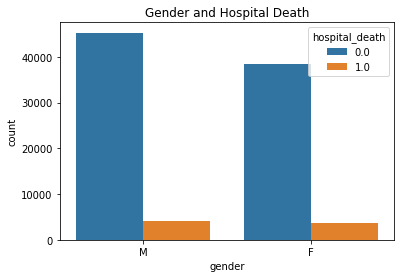

In [0]:
ax=plt.axes()
sns.countplot(x="gender", hue="hospital_death",data=training_df_cleaned,ax=ax)
ax.set_title('Gender and Hospital Death')
# 1 is death, 0 is alive
survived_gender = survived_df['gender'].value_counts()
death_gender = death_df['gender'].value_counts()
print("Male ratio of death over alive: {}".format(death_gender.M/float(survived_gender.M)))
print("Female ratio of death over alive: {}".format(death_gender.F/float(survived_gender.F)))

**Relationship between Ethnicity and survivability**


This dataset have more cases on Caucasian than other races, which relates the general population. But Hispanic has a highest ratio of deaths over survival.

In [0]:
ratio_deathoverlife = death_df['ethnicity'].value_counts()/survived_df['ethnicity'].value_counts()
ratio_deathoverlife

African American    0.085256
Asian               0.089768
Caucasian           0.095604
Hispanic            0.109942
Native American     0.097493
Other/Unknown       0.087789
Name: ethnicity, dtype: float64

Text(0.5, 1.0, 'Ethnicity and Hospital Death')

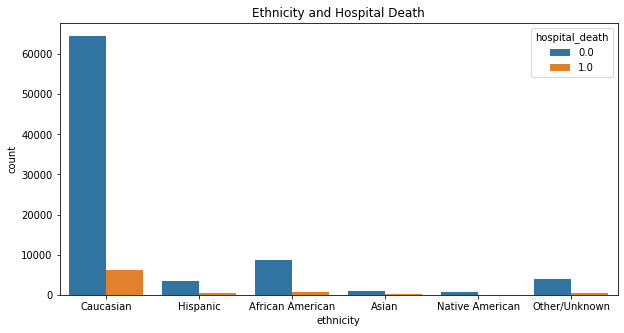

In [0]:
plt.figure(figsize=(10,5))

ax=plt.axes()
sns.countplot(x="ethnicity", hue="hospital_death",data=training_df_cleaned,ax=ax)
ax.set_title('Ethnicity and Hospital Death')
# 1 is death, 0 is alive

**Relationship between BMI and survivability**

Histogram plot below shows us that chances of death is higher for BMI lower than 25

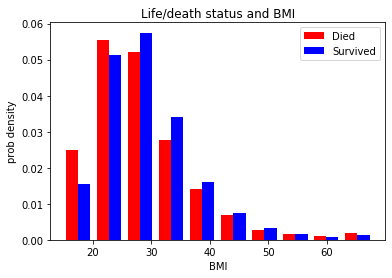

In [0]:
plt.hist([death_df['bmi'],survived_df['bmi']],bins=10,density=True,
         label=['Died','Survived'],color=['red','blue'])
plt.title("Life/death status and BMI")
plt.xlabel('BMI')
plt.ylabel('prob density')
plt.legend(loc='upper right')

**Relationship between Weight and survivability**

Patients weighed from 80kg to 150kg seem to have a higher chance of survival as compared to other weight level. 

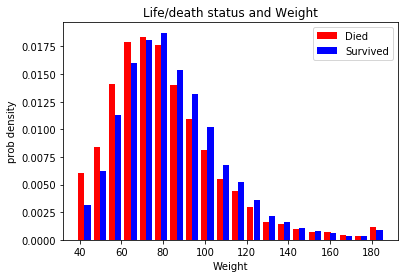

In [0]:
plt.hist([death_df['weight'],survived_df['weight']],bins=20,density=True,
         label=['Died','Survived'],color=['red','blue'])
plt.title("Life/death status and Weight")
plt.xlabel('Weight')
plt.ylabel('prob density')
plt.legend(loc='upper right')

**Relationship between pre-ICU admission days and survivability**

Patients who have total 5 or more days in the length of stay between hospital admission and unit admission have a lesser chance of survival.

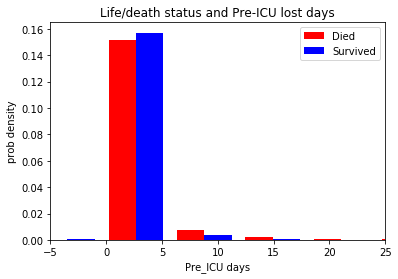

In [0]:
plt.hist([death_df['pre_icu_los_days'],survived_df['pre_icu_los_days']],bins=30,density=True,
         label=['Died','Survived'],color=['red','blue'])
plt.xlim((-5,25))
plt.title("Life/death status and Pre-ICU lost days")
plt.xlabel('Pre_ICU days')
plt.ylabel('prob density')
plt.legend(loc='upper right')

**Negative values in pre_icu_los_days seem to indicate that patients went straight to ICU admission without hospital admission?**

In [0]:
death_df['pre_icu_los_days'].describe()

count    7915.000000
mean        1.348633
std         3.552734
min       -13.773438
25%         0.035431
50%         0.139526
75%         0.794922
max        84.375000
Name: pre_icu_los_days, dtype: float64

In [0]:
survived_df['pre_icu_los_days'].describe()

count    83798.000000
mean              NaN
std          0.000000
min        -24.953125
25%          0.035431
50%          0.138916
75%          0.397217
max        159.125000
Name: pre_icu_los_days, dtype: float64

**ICU type and survivability**

The highest number of survivals and deaths are on Medical Surgery ICU in this dataset. But highest ratio of death over survival is MICU followed by Cardiac ICU.

In [0]:
ratio_ICUtype_deathoverlife = death_df['icu_type'].value_counts()/survived_df['icu_type'].value_counts()
ratio_ICUtype_deathoverlife

CCU-CTICU       0.081947
CSICU           0.058270
CTICU           0.064062
Cardiac ICU     0.115367
MICU            0.137472
Med-Surg ICU    0.095884
Neuro ICU       0.090664
SICU            0.080930
Name: icu_type, dtype: float64

Text(0.5, 1.0, 'ICU type and Hospital Death')

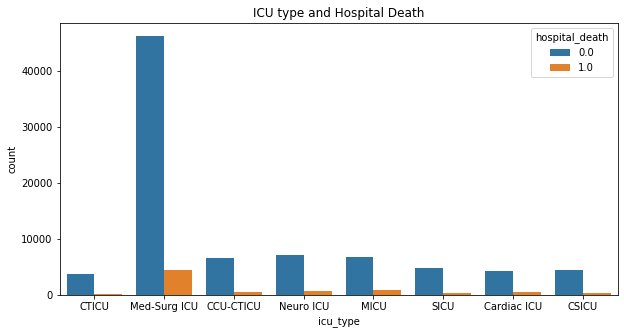

In [0]:
plt.figure(figsize=(10,5))

ax= plt.axes()
sns.countplot(x="icu_type", hue="hospital_death",data=training_df_cleaned,
              ax=ax)
ax.set_title('ICU type and Hospital Death')
# 1 is death, 0 is alive

**Hospital admission source and hospital death**

Text(0.5, 1.0, 'Hosp. admit source and Hospital Death')

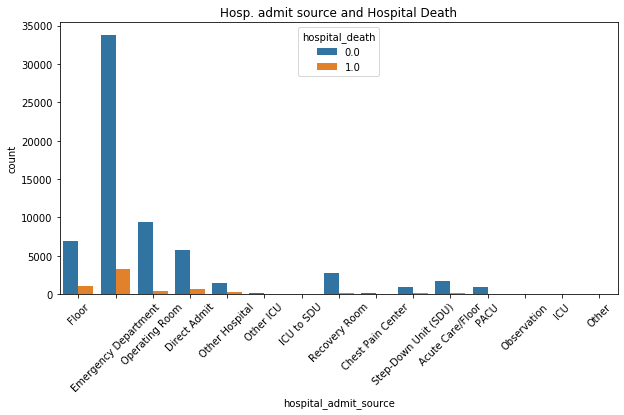

In [0]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)

ax= sns.countplot(x="hospital_admit_source",hue="hospital_death", 
                  data=training_df_cleaned)
ax.set_title('Hosp. admit source and Hospital Death')
# 1 is death, 0 is alive

**ICU stay type and hospital death**

Readmission or transfer does not have much effect on survivability in ICU

Text(0.5, 1.0, 'ICU stay type and Hospital Death')

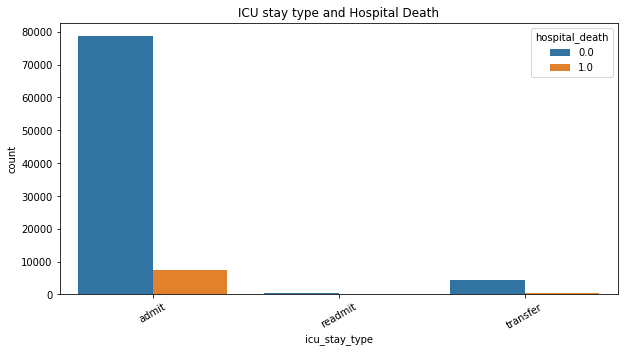

In [0]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=30)

ax= sns.countplot(x="icu_stay_type",hue="hospital_death", 
                  data=training_df_cleaned)
ax.set_title('ICU stay type and Hospital Death')
# 1 is death, 0 is alive

# Pre-processing data

## Removing columns with >70% missing values for train and test

We can remove lab and vital variables with more than 70% missing values, which are not meaningful for model training

In [34]:
eigthypercmissing = cal_missing_val(training_df_cleaned).sort_values(by=['MissingValue'],ascending=False)
colstoberemoved = eigthypercmissing [eigthypercmissing ['MissingValue'] > 70].index.values
colstoberemoved

array(['h1_bilirubin_min', 'h1_bilirubin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_albumin_max', 'h1_albumin_min',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max',
       'h1_arterial_ph_max', 'h1_arterial_ph_min', 'h1_hco3_max',
       'h1_hco3_min', 'h1_arterial_pco2_min', 'h1_arterial_pco2_max',
       'h1_wbc_max', 'h1_wbc_min', 'h1_arterial_po2_max',
       'h1_arterial_po2_min', 'h1_calcium_max', 'h1_calcium_min',
       'h1_platelets_max', 'h1_platelets_min', 'h1_bun_max', 'h1_bun_min',
       'h1_creatinine_max', 'h1_creatinine_min', 'h1_diasbp_invasive_min',
       'h1_diasbp_invasive_max', 'h1_sysbp_invasive_max',
       'h1_sysbp_invasive_min', 'h1_mbp_invasive_min',
       'h1_mbp_invasive_max', 'h1_hematocrit_max', 'h1_hematocrit_min',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_min',
       'h1_sodium_max', 'h1_potassium_max', 'h1_potassium_min',
       'pao2_apache', 'ph_apache', 'paco2_for_ph_apache', 'paco2_apache',
       'fio2_apache'

When we check with test dataset, the same variables have more than 70% missing values

In [16]:
eigthypercmissing_test = cal_missing_val(test_df).sort_values(by=['MissingValue'],ascending=False)
colstoberemoved_test = eigthypercmissing_test[eigthypercmissing_test['MissingValue'] > 70].index.values
colstoberemoved_test

array(['hospital_death', 'h1_bilirubin_min', 'h1_bilirubin_max',
       'h1_albumin_min', 'h1_albumin_max', 'h1_lactate_max',
       'h1_lactate_min', 'h1_pao2fio2ratio_max', 'h1_pao2fio2ratio_min',
       'h1_arterial_pco2_max', 'h1_arterial_pco2_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_arterial_ph_min',
       'h1_arterial_ph_max', 'h1_hco3_max', 'h1_hco3_min',
       'h1_platelets_max', 'h1_platelets_min', 'h1_calcium_min',
       'h1_calcium_max', 'h1_wbc_max', 'h1_wbc_min',
       'h1_mbp_invasive_max', 'h1_mbp_invasive_min',
       'h1_diasbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_bun_min',
       'h1_bun_max', 'h1_sysbp_invasive_max', 'h1_sysbp_invasive_min',
       'h1_creatinine_min', 'h1_creatinine_max', 'h1_hemaglobin_max',
       'h1_hemaglobin_min', 'h1_hematocrit_min', 'h1_hematocrit_max',
       'h1_sodium_max', 'h1_sodium_min', 'paco2_for_ph_apache',
       'ph_apache', 'pao2_apache', 'paco2_apache', 'fio2_apache',
       'h1_potassium_min', 

So, we can remove the above columns for both train and test

* total train and test columns 186
* columns to be removed due to more than 70% missing values = 55
* remainining number of columns = 131

#### Remove high missing value columns in train

In [17]:
training_df_cleaned2 = training_df_cleaned.drop(colstoberemoved, axis=1)
cal_missing_val(training_df_cleaned2).sort_values(by=['MissingValue'],ascending=False)

,MissingValue
d1_arterial_ph_min,65.555592
d1_arterial_ph_max,65.555592
d1_arterial_pco2_max,64.626607
d1_arterial_pco2_min,64.626607
d1_arterial_po2_min,64.616794
...,...
icu_type,0.000000
pre_icu_los_days,0.000000
readmission_status,0.000000
apache_post_operative,0.000000


#### Remove high missing value columns in test

In [18]:
test_df_cleaned = test_df.drop(colstoberemoved, axis=1)
cal_missing_val(test_df_cleaned).sort_values(by=['MissingValue'],ascending=False)

,MissingValue
hospital_death,100.000000
d1_arterial_pco2_max,65.571894
d1_arterial_pco2_min,65.571894
d1_arterial_po2_max,64.447441
d1_arterial_po2_min,64.447441
...,...
icu_type,0.000000
pre_icu_los_days,0.000000
readmission_status,0.000000
apache_post_operative,0.000000


## Regrouping categorical variables

#### Combine train and test dataset for the above purpose

In [19]:
# get length of train and test set
train_length = len(training_df_cleaned2)
test_length = len(test_df_cleaned)
print('length of train set:',train_length)
print('length of test set:',test_length)

# combine train and test to get all the categorical levels for the concerned columns
combined_df = pd.concat([training_df_cleaned2, test_df_cleaned], axis=0)
print('shape of combined train and test set:',combined_df.shape)

# filter categorical columns
categoricalcol = combined_df.select_dtypes(include=['object','category'])
print('list of categorical columns:',categoricalcol.columns)

length of train set: 91713
length of test set: 39308
shape of combined train and test set: (131021, 131)
list of categorical columns: Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')


In [20]:
# Checking unique values for each categorical columns
for i in categoricalcol.columns:
    n = list(categoricalcol[i].unique())
    print("Unique values for ", i)
    print(n)

Unique values for  ethnicity
['Caucasian', nan, 'Hispanic', 'African American', 'Asian', 'Native American', 'Other/Unknown']
Unique values for  gender
['M', 'F', nan]
Unique values for  hospital_admit_source
['Floor', 'Emergency Department', 'Operating Room', nan, 'Direct Admit', 'Other Hospital', 'Other ICU', 'ICU to SDU', 'Recovery Room', 'Chest Pain Center', 'Step-Down Unit (SDU)', 'Acute Care/Floor', 'PACU', 'Observation', 'ICU', 'Other']
Unique values for  icu_admit_source
['Floor', 'Accident & Emergency', 'Operating Room / Recovery', 'Other Hospital', 'Other ICU', nan]
Unique values for  icu_stay_type
['admit', 'readmit', 'transfer']
Unique values for  icu_type
['CTICU', 'Med-Surg ICU', 'CCU-CTICU', 'Neuro ICU', 'MICU', 'SICU', 'Cardiac ICU', 'CSICU']
Unique values for  apache_3j_bodysystem
['Sepsis', 'Respiratory', 'Metabolic', 'Cardiovascular', 'Trauma', 'Neurological', 'Gastrointestinal', 'Genitourinary', nan, 'Hematological', 'Musculoskeletal/Skin', 'Gynecological']
Unique va

**Observations**:
1. There are NA values for gender, ICU_admit_source, Apache 3J body system and Apache 2 body system.

2. For hospital admit source, the visualization show us that "Other ICU", "Observation", "ICU", and "Other" have less values. So, we can combine Other ICU with ICU and ICU to SDU with SDU and Other with Other hospital. Observation can be combined with Recovery Room. 

3. For ICU type, seems like CTICU, CCU-CTICU, CSICU, and Cardiac ICU admit patients mainly related to Cardiovascular diagnosis.

4. In Apache 2 body system, there are two levels with same name: Undefined diagnoses.But apache 3j-body system provides more granular sub-diagnosis for the ICU admission. So, apache_3j_bodysystem is a more informative variable than apache_2_bodysystem.

**Next steps**:

1. To change NA to unknown

2. Combine "Other ICU" with "ICU", "ICU to SDU" to "SDU", and "Other" to "Other hospital".

3. Group CTICU, CCU-CTICU, CSICU, CardiacICU to Cardiacgroup_ICU

4. Remove apache_3J_bodysystem 


In [21]:
combined_df['ethnicity']= combined_df['ethnicity'].replace(np.nan,'Other/Unknown')

combined_df['gender']= combined_df['gender'].replace(np.nan,'Unknown')

combined_df['hospital_admit_source'] = combined_df['hospital_admit_source'].replace({'Other ICU': 'ICU','ICU to SDU':'SDU', 'Step-Down Unit (SDU)': 'SDU',
         'Other Hospital':'Other','Observation': 'Recovery Room'})

combined_df['hospital_admit_source'] = combined_df['hospital_admit_source'].replace(np.nan,'Unknown')

combined_df['icu_stay_type']= combined_df['icu_stay_type'].replace(np.nan,'Unknown')

combined_df['icu_admit_source']= combined_df['icu_admit_source'].replace(np.nan,'Unknown')

combined_df['icu_type'] = combined_df['icu_type'].replace({'CCU-CTICU': 'Cardiacgroup_ICU', 
                                                           'CTICU':'Cardiacgroup_ICU', 
                                                           'Cardiac ICU':'Cardiacgroup_ICU', 
                                                           'CSICU':'Cardiacgroup_ICU'})

combined_df['apache_3j_bodysystem']= combined_df['apache_3j_bodysystem'].replace(np.nan,'Unknown')

combined_df = combined_df.drop('apache_2_bodysystem', axis=1)
print(combined_df.shape)

(131021, 130)


In [22]:
# Checking unique values for each categorical columns
categoricalcol2 = combined_df.select_dtypes(include=['object','category'])
for i in categoricalcol2.columns:
    n = list(categoricalcol2[i].unique())
    print("Unique values for ", i)
    print(n)

Unique values for  ethnicity
['Caucasian', 'Other/Unknown', 'Hispanic', 'African American', 'Asian', 'Native American']
Unique values for  gender
['M', 'F', 'Unknown']
Unique values for  hospital_admit_source
['Floor', 'Emergency Department', 'Operating Room', 'Unknown', 'Direct Admit', 'Other', 'ICU', 'SDU', 'Recovery Room', 'Chest Pain Center', 'Acute Care/Floor', 'PACU']
Unique values for  icu_admit_source
['Floor', 'Accident & Emergency', 'Operating Room / Recovery', 'Other Hospital', 'Other ICU', 'Unknown']
Unique values for  icu_stay_type
['admit', 'readmit', 'transfer']
Unique values for  icu_type
['Cardiacgroup_ICU', 'Med-Surg ICU', 'Neuro ICU', 'MICU', 'SICU']
Unique values for  apache_3j_bodysystem
['Sepsis', 'Respiratory', 'Metabolic', 'Cardiovascular', 'Trauma', 'Neurological', 'Gastrointestinal', 'Genitourinary', 'Unknown', 'Hematological', 'Musculoskeletal/Skin', 'Gynecological']


## Drop columns with single value and all unique values

Justification: Not useful for modelling and analysis

In [23]:
for i in combined_df.columns:
    if combined_df[i].nunique() == 1:
        print('only 1 unique value:', i)
    elif combined_df[i].nunique() == len(combined_df):
        print('every row is unique value:', i)
    else: pass

every row is unique value: encounter_id
every row is unique value: patient_id
only 1 unique value: readmission_status


In [24]:
# we can drop the three columns above which are not used for prediction
combined_df = combined_df.drop(['encounter_id','patient_id','readmission_status'], axis=1)
combined_df.shape

(131021, 127)

## Split dataset back from combined to train and test




In [25]:
training_df_cleaned3 = combined_df[:train_length]
test_df_cleaned2 = combined_df[train_length:]
print(training_df_cleaned3.shape)
print(test_df_cleaned2.shape)

(91713, 127)
(39308, 127)


## Imputing missing values



In [5]:
apachevariables2 = ['albumin_apache','apache_2_diagnosis','apache_3j_diagnosis',
                  'apache_post_operative', 'arf_apache', 'bilirubin_apache','bun_apache',
                   'creatinine_apache','gcs_eyes_apache','gcs_motor_apache',
                   'gcs_unable_apache','gcs_verbal_apache','glucose_apache','heart_rate_apache',
                   'hematocrit_apache','intubated_apache','map_apache','resprate_apache',
                   'sodium_apache','temp_apache','urineoutput_apache','ventilated_apache',
                   'wbc_apache','apache_4a_hospital_death_prob','apache_4a_icu_death_prob',
                   'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression',
                   'leukemia','lymphoma','solid_tumor_with_metastasis','apache_3j_bodysystem']

In [8]:
# remove columns with zero missing values from apache variables:'apache_post_operative','apache_3j_bodysystem'
apachevariables3 = ['albumin_apache','apache_2_diagnosis','apache_3j_diagnosis',
                   'arf_apache', 'bilirubin_apache','bun_apache',
                   'creatinine_apache','gcs_eyes_apache','gcs_motor_apache',
                   'gcs_unable_apache','gcs_verbal_apache','glucose_apache','heart_rate_apache',
                   'hematocrit_apache','intubated_apache','map_apache','resprate_apache',
                   'sodium_apache','temp_apache','urineoutput_apache','ventilated_apache',
                   'wbc_apache','apache_4a_hospital_death_prob','apache_4a_icu_death_prob',
                   'aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression',
                   'leukemia','lymphoma','solid_tumor_with_metastasis','aids','cirrhosis',
                   'diabetes_mellitus','hepatic_failure','immunosuppression','leukemia',
                   'lymphoma','solid_tumor_with_metastasis']

When arf_apache variable (i.e. when patient had renal failure during the 1st 24 hours of unit stay) is null, there seems to be missing values for the other apache variable columns for train and test set

In [26]:
print('total apache columns:', 
      len(apachevariables2))
print('shape of missing values train ',
      training_df_cleaned3[training_df_cleaned3['arf_apache'].isna()==True][apachevariables3].shape)
print('shape of missing values test ', 
      test_df_cleaned2[test_df_cleaned2['arf_apache'].isna()==True][apachevariables3].shape)

total apache columns: 34
shape of missing values train  (715, 40)
shape of missing values test  (179, 40)


## Fill the missing apache variables with -1 for arf_apache = NA

In [27]:
training_df_cleaned3.loc[(training_df_cleaned3['arf_apache'].isna()==True), apachevariables3] = -1

test_df_cleaned2.loc[(test_df_cleaned2['arf_apache'].isna()==True),apachevariables3] = -1

**Download and read file for analysis after break**

In [12]:
# training_df_cleaned3.to_csv('train3.csv')
# test_df_cleaned2.to_csv('test2.csv')

# training_df_cleaned3 = pd.read_csv(datapath+'/train3.csv')
# test_df_cleaned2 = pd.read_csv(datapath+'/test2.csv')

In [13]:
reduce_memory(training_df_cleaned3)
reduce_memory(test_df_cleaned2)

Mem. usage decreased to 24.67 Mb (72.2% reduction)
Mem. usage decreased to 10.83 Mb (71.6% reduction)


10.833873748779297

## Impute missing values using the column mean grouped by apache 3j bodysystem diagnosis

Compare the distribution of lab vital variables for train and test

In [26]:
train_diagnosis = pd.pivot_table(training_df_cleaned3, values=labvitals_selected,
                          index=['apache_3j_bodysystem'], aggfunc=np.mean)

train_diagnosis

,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min
apache_3j_bodysystem,,,,,,,,,,,,,,,,,,,,,
Cardiovascular,24.359375,22.718750,8.515625,8.304688,1.478516,1.370117,86.6875,50.46875,87.0000,50.71875,...,21.656250,16.171875,98.1250,95.1875,134.000,116.6250,133.750,117.4375,36.53125,36.40625
Gastrointestinal,28.828125,26.890625,8.007812,7.816406,1.426758,1.323242,86.1875,48.65625,86.2500,48.68750,...,22.078125,16.593750,98.3125,95.5000,131.125,114.8750,130.750,114.6875,36.75000,36.62500
Genitourinary,51.843750,45.906250,8.210938,7.906250,3.740234,3.183594,88.4375,48.81250,88.5000,48.84375,...,22.500000,17.312500,97.9375,95.1250,130.625,114.7500,130.500,114.6250,36.71875,36.65625
Gynecological,13.367188,12.093750,7.886719,7.609375,0.998047,0.910645,87.6875,53.56250,87.7500,53.50000,...,20.171875,15.226562,98.9375,96.7500,134.875,119.8750,135.125,120.1875,36.59375,36.46875
Hematological,32.781250,31.140625,8.171875,8.039062,1.804688,1.699219,84.5625,48.31250,84.6250,48.37500,...,23.453125,18.468750,98.5000,95.8125,126.375,113.0625,126.375,113.0000,36.93750,36.81250
Metabolic,20.828125,17.218750,8.484375,8.140625,1.328125,1.143555,90.9375,53.56250,90.9375,53.56250,...,21.937500,17.171875,98.3125,96.2500,133.375,119.6250,133.375,119.6250,36.68750,36.62500
Musculoskeletal/Skin,24.718750,22.906250,8.125000,7.972656,1.419922,1.313477,84.3125,48.31250,84.3125,48.31250,...,21.171875,15.632812,98.2500,95.3750,130.250,113.6875,129.750,113.3750,36.84375,36.71875
Neurological,18.625000,17.718750,8.617188,8.484375,1.125000,1.069336,94.6875,53.28125,94.6875,53.28125,...,21.484375,16.328125,98.2500,96.0625,145.500,128.1250,145.500,128.1250,36.75000,36.65625
Respiratory,24.984375,23.703125,8.476562,8.351562,1.295898,1.220703,89.7500,50.21875,89.8125,50.25000,...,24.875000,19.140625,97.6250,94.1875,133.625,116.3750,133.500,116.3125,36.84375,36.75000


In [27]:
test_diagnosis = pd.pivot_table(test_df_cleaned2, values=labvitals_selected,
                          index=['apache_3j_bodysystem'], aggfunc=np.mean)

test_diagnosis

,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min
apache_3j_bodysystem,,,,,,,,,,,,,,,,,,,,,
Cardiovascular,24.875000,22.843750,8.523438,8.242188,1.554688,1.413086,86.5625,48.93750,87.0000,48.90625,...,21.406250,15.750000,98.3125,95.5625,132.3750,113.3125,132.2500,114.0000,36.50000,36.37500
Gastrointestinal,28.203125,25.890625,8.062500,7.820312,1.436523,1.307617,86.8125,47.40625,86.9375,47.40625,...,21.531250,16.265625,98.3125,95.7500,130.1250,112.6250,129.8750,112.3750,36.78125,36.65625
Genitourinary,53.531250,45.812500,8.234375,7.816406,4.101562,3.367188,87.0625,47.18750,87.1250,47.18750,...,22.250000,16.953125,98.3125,95.7500,128.1250,111.8750,127.7500,111.2500,36.68750,36.56250
Gynecological,13.335938,12.007812,7.824219,7.488281,0.932617,0.831055,86.9375,51.15625,87.2500,51.06250,...,21.234375,15.195312,99.0625,97.1875,129.8750,111.5000,129.5000,111.5000,36.56250,36.37500
Hematological,33.500000,31.328125,8.234375,8.093750,1.548828,1.453125,86.8750,48.18750,86.8750,48.18750,...,23.812500,17.953125,98.5000,95.6875,124.8125,112.8750,124.8125,112.8125,36.96875,36.84375
Metabolic,22.609375,18.078125,8.484375,8.093750,1.428711,1.187500,91.3125,53.37500,91.3750,53.37500,...,21.562500,16.875000,98.5000,96.4375,134.1250,120.0000,134.0000,119.7500,36.75000,36.65625
Musculoskeletal/Skin,22.390625,20.515625,8.101562,7.894531,1.326172,1.202148,84.5625,47.50000,84.6875,47.50000,...,20.234375,14.703125,98.3125,95.2500,129.1250,112.4375,128.7500,112.0625,36.93750,36.75000
Neurological,18.203125,17.156250,8.593750,8.437500,1.113281,1.048828,94.0625,52.18750,94.2500,52.18750,...,21.203125,15.648438,98.5000,96.1250,146.2500,126.8125,145.8750,126.3750,36.81250,36.68750
Respiratory,25.625000,23.968750,8.531250,8.351562,1.363281,1.262695,88.6875,49.65625,88.8750,49.65625,...,24.765625,19.062500,97.6250,94.5000,134.1250,116.2500,133.6250,115.8125,36.87500,36.78125


Combined dataset to impute NANs

In [28]:
# get length of train and test set
train_length = len(training_df_cleaned3)
test_length = len(test_df_cleaned2)
print('length of train set:',train_length)
print('length of test set:',test_length)

# combine train and test to get all the categorical levels for the concerned columns
combined_df = pd.concat([training_df_cleaned3, test_df_cleaned2], axis=0)
print('shape of combined train and test set:',combined_df.shape)

length of train set: 91713
length of test set: 39308
shape of combined train and test set: (131021, 127)


Get columns with NANs

In [29]:
remainingmissingcols = combined_df.columns[combined_df.isna().any()].tolist()

remainingmissingcols.remove('hospital_death')

len(remainingmissingcols)

103

Impute 103 remaining missing columns using column mean grouped by apache 3j bodysystem

In [30]:
combined_df= combined_df.reset_index(drop=True)

In [31]:
combined_df[remainingmissingcols]= combined_df[remainingmissingcols].fillna\
(combined_df.groupby(['apache_3j_bodysystem'], sort=False)[remainingmissingcols].transform('mean'))

Validate whether imputation is successful

In [32]:
combined_df.columns[combined_df.isna().any()].tolist()

['hospital_death']

Split back the data into train and test

In [33]:
training_df_cleaned4 = combined_df[:train_length]
test_df_cleaned3 = combined_df[train_length:]
print(training_df_cleaned4.shape)
print(test_df_cleaned3.shape)

(91713, 127)
(39308, 127)


In [5]:
# training_df_cleaned4.to_csv('train4.csv')
# test_df_cleaned3.to_csv('test3.csv')
training_df_cleaned4 = pd.read_csv(datapath+'/train4.csv')
test_df_cleaned3 = pd.read_csv(datapath+'/test3.csv')

## Convert predictors with less than/equal to 12 unique values into categorical

In [6]:
col_train = training_df_cleaned4.columns
factorvariables_train = []
for i in col_train:
    if training_df_cleaned4[i].nunique() <= 12:
        factorvariables_train.append(i)
factorvariables_train.remove('hospital_death')

In [7]:
col_test = test_df_cleaned3.columns
factorvariables_test = []
for i in col_test:
    if test_df_cleaned3[i].nunique() <= 12:
        factorvariables_test.append(i)
factorvariables_test.remove('hospital_death')

In [8]:
training_df_cleaned4[factorvariables_train] =  training_df_cleaned4 \
    [factorvariables_train].apply(lambda x: x.astype('category'), axis=0)

test_df_cleaned3[factorvariables_test] = test_df_cleaned3 \
    [factorvariables_test].apply(lambda x: x.astype('category'), axis=0)

print('train col type:')
print(training_df_cleaned4[factorvariables_train].dtypes)

print('test col type:')
print(test_df_cleaned3[factorvariables_test].dtypes)

train col type:
elective_surgery               category
ethnicity                      category
gender                         category
hospital_admit_source          category
icu_admit_source               category
icu_stay_type                  category
icu_type                       category
apache_post_operative          category
arf_apache                     category
gcs_unable_apache              category
intubated_apache               category
ventilated_apache              category
aids                           category
cirrhosis                      category
diabetes_mellitus              category
hepatic_failure                category
immunosuppression              category
leukemia                       category
lymphoma                       category
solid_tumor_with_metastasis    category
apache_3j_bodysystem           category
dtype: object
test col type:
elective_surgery               category
ethnicity                      category
gender                         cate

## Use Label Encoder to label string variables

In [9]:
numerical_cols   = training_df_cleaned4._get_numeric_data().columns
categorical_cols = list(set(col_train)- set(numerical_cols))

for col in categorical_cols:
    training_df_cleaned4[col] = training_df_cleaned4[col].astype('str')
    test_df_cleaned3[col]     = test_df_cleaned3[col].astype('str')
    
    # fit label encoder
    labele = LabelEncoder().fit(np.unique(training_df_cleaned4[col].unique().tolist()+ \
                                          test_df_cleaned3[col].unique().tolist()))
    
    # ensure no zero as the label
    training_df_cleaned4[col] = labele.transform(training_df_cleaned4[col])+1
    test_df_cleaned3[col]     = labele.transform(test_df_cleaned3[col])+1
    
    training_df_cleaned4[col] = training_df_cleaned4[col].replace(np.nan, ''). \
                                astype('int').astype('category')
    test_df_cleaned3[col] = test_df_cleaned3[col].replace(np.nan, ''). \
                            astype('int').astype('category')
    

Since some hospital id is not present in test and there are many unique ids, this variable may not be a useful feature. So, will remove this variable from model

In [93]:
print(training_df_cleaned4['hospital_id'].nunique())
print(test_df_cleaned3['hospital_id'].nunique())

147
66


## Drop high correlated variables (> 0.9)

Generate matrix of high correlated variables (correlation coefficient > 0.9) from combined train and test dataset

In [39]:
corr2 = (combined_df.corr(method="spearman"))
# due to symmetrical marix, we generate a triangle side of correlation matrix (upper) without diagonal (k=1)
corr_values = (corr2.where(np.triu(np.ones(corr2.shape),
                                   k=1).astype(np.bool))).stack()

# Sort the correlation values by highest to lowest
corr_values = (corr_values.sort_values(ascending=False))

corr_values[corr_values > 0.9]

d1_inr_max                     h1_inr_max                   1.000000
d1_inr_min                     h1_inr_min                   1.000000
d1_diasbp_min                  d1_diasbp_noninvasive_min    0.991931
d1_sysbp_max                   d1_sysbp_noninvasive_max     0.991920
d1_sysbp_min                   d1_sysbp_noninvasive_min     0.991415
d1_diasbp_max                  d1_diasbp_noninvasive_max    0.990132
d1_mbp_min                     d1_mbp_noninvasive_min       0.990002
d1_mbp_max                     d1_mbp_noninvasive_max       0.984864
h1_sysbp_max                   h1_sysbp_noninvasive_max     0.976791
h1_sysbp_min                   h1_sysbp_noninvasive_min     0.970751
d1_bun_max                     d1_bun_min                   0.970079
d1_bilirubin_max               d1_bilirubin_min             0.969174
d1_creatinine_max              d1_creatinine_min            0.969158
h1_mbp_min                     h1_mbp_noninvasive_min       0.967462
h1_mbp_max                     h1_

In [12]:
training_df_cleaned4= pd.concat([training_df_cleaned['encounter_id'],
                                 training_df_cleaned4], axis=1)

test_df_cleaned3 = test_df_cleaned3.reset_index(drop=True)
test_df_cleaned3 = pd.concat([test_df['encounter_id'],
                                 test_df_cleaned3], axis=1)

In [13]:
variablestodrop = ['hospital_id','h1_inr_min','d1_sysbp_noninvasive_max',
                  'd1_sysbp_noninvasive_min','d1_diasbp_noninvasive_min',
                  'd1_diasbp_noninvasive_max','d1_mbp_noninvasive_min',
                  'd1_mbp_noninvasive_max','h1_sysbp_noninvasive_max',
                  'h1_sysbp_noninvasive_min','d1_bun_min','d1_bilirubin_min',
                  'd1_creatinine_min','h1_mbp_noninvasive_min',
                  'h1_mbp_noninvasive_max','h1_diasbp_noninvasive_min',
                  'h1_diasbp_noninvasive_max','d1_hematocrit_min',
                  'd1_platelets_min','d1_hematocrit_max','d1_inr_min',
                  'd1_albumin_min','h1_glucose_min','d1_wbc_min',
                  'd1_hematocrit_min','h1_temp_min','d1_hemaglobin_min',
                  'd1_albumin_min','d1_hematocrit_min','d1_bun_max']

final_train = training_df_cleaned4.drop(variablestodrop, axis=1)
final_test  = test_df_cleaned3.drop(variablestodrop, axis =1)
print(final_train.shape)
print(final_test.shape)

(91713, 101)
(39308, 101)


# Split training dataset into train and validation

In [146]:
Train, Validation = train_test_split(final_train, 
                                     test_size =0.3, random_state=303)

In [3]:
# Train.to_csv('trainsplit.csv')
# Validation.to_csv('valsplit.csv')
Train = pd.read_csv(datapath+'/trainsplit.csv')
Validation = pd.read_csv(datapath+'/valsplit.csv')

In [14]:
X_train = Train.copy().drop('hospital_death', axis = 1)
y_train = Train[['encounter_id','hospital_death']]
X_val = Validation.copy().drop('hospital_death', axis = 1)
y_val = Validation[['encounter_id','hospital_death']]
X_test = final_test.copy().drop('hospital_death', axis = 1)
y_test = final_test[['encounter_id', 'hospital_death']]

In [15]:
X_train.set_index('encounter_id', inplace = True)
y_train.set_index('encounter_id', inplace = True)
X_val.set_index('encounter_id', inplace = True)
y_val.set_index('encounter_id', inplace = True)
X_test.set_index('encounter_id', inplace = True)
y_test.set_index('encounter_id', inplace = True)

In [16]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(sum(y_train.hospital_death == 1)*100/len(y_train))
print(sum(y_val.hospital_death == 1)*100/len(y_val))
(sum(training_df_cleaned.hospital_death == 1)*100/len(training_df_cleaned))

(64199, 99)
(27514, 99)
(39308, 99)
8.69639714014237
8.475685105764338


8.630183289173836

# Model

## Implement logistic regression

**Parameter tuning**

In [50]:
# set penalty as L2
lr = LogisticRegression(penalty = 'l2')

# tune parameters for logistic using Randomized Search CV
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

# Run Randomized Search if parameters needed to be retuned
# logreg = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv = 5, n_jobs=-1)
# logreg_result = logreg.fit(X_train, y_train)

# Print out the best parameter
# print("Best: %f using %s" % (logreg_result.best_score_, logreg_result.best_params_))

Best: 0.923566 using {'max_iter': 100, 'dual': False, 'C': 2.5}


**Run model with best parameter**

In [27]:
# run LR using best parameter
logreg = LogisticRegression(penalty = 'l2', max_iter=100, dual=False, C=2.5)
logreg.fit(X_train, y_train)

# predict on validation
y_pred = logreg.predict(X_val)
print('Accuracy of logistic regression classifier on valid set: {:.2f}'. \
      format(logreg.score(X_val, y_val)))

Accuracy of logistic regression classifier on valid set: 0.93


In [17]:
import pickle

# Save logistic to file in the current working directory
logit_filename = "Logistic.pkl"
# with open(logit_filename, 'wb') as logitfile:
#    pickle.dump(logreg, logitfile)
    
# Load from file
with open(logit_filename, 'rb') as logitfile:
    pickle_logitmodel = pickle.load(logitfile)

In [30]:
logreg_result = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(logreg_result)
logreg_result1 = classification_report(y_val, y_pred)
print("Classification Report:",)
print (logreg_result1)
logreg_result2 = accuracy_score(y_val,y_pred)
print("Accuracy:",logreg_result2)

Confusion Matrix:
[[24857   325]
 [ 1722   610]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     25182
           1       0.65      0.26      0.37      2332

    accuracy                           0.93     27514
   macro avg       0.79      0.62      0.67     27514
weighted avg       0.91      0.93      0.91     27514

Accuracy: 0.9256015119575489


## Implement boosting (LightGBM)

LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

To get good results using a leaf-wise tree, these are some important parameters:
1. num_leaves - control complexity of the tree model (theory: set 2^max depth to obtain same number of leaves as depth-wise tree. but, simple conversion is not good for practice. Why? Leaf-wise tree is typically much deeper than a depth-wise tree for a fixed no of leaves). Unconstrained depth can indece over-fitting

2. min_data_in_leaf (important parameter to prevent over-fitting- setting it large can avoid growing too deep a tree (depending on no of training samples and num_leaves- too large value can avoid growing too deep a tree) (100/1000 should be good for a large dataset)

3. max_depth - to lmite tree depth explicitly

4. max bin - use small value to deal with over-fitting but large for higher accuracy

**Hyperparameter tuning**

In [31]:
# tuned the parameters for max bin, max depth and num leaves for LightGBM using
# randomized search

clf = lgb.LGBMClassifier(silent=True, random_state = 303, metric='roc_auc')

params ={'max_bin' : sp_randint(1, 1000), 
         'max_depth': [2,3,4,5,6,7,8,9],
         'num_leaves': sp_randint(6, 1500)}

fit_params={"early_stopping_rounds":3, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_train, y_train),(X_val,y_val)],
            'eval_names': ['train','valid'],
            'verbose': 300,
            'categorical_feature': 'auto'}

In [32]:
gs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=params, 
                        scoring='roc_auc',cv=5, refit=True,random_state=303,verbose=True)

In [33]:
# fit gs using fit params to get the best params
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[61]	train's auc: 0.941423	valid's auc: 0.895674
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[60]	train's auc: 0.939413	valid's auc: 0.895989
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.953676	valid's auc: 0.898214
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[94]	train's auc: 0.952875	valid's auc: 0.896641
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[80]	train's auc: 0.948268	valid's auc: 0.895857
Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[74]	train's auc: 0.946744	valid's auc: 0.896705
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.3min finished


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[79]	train's auc: 0.953943	valid's auc: 0.898089
Best score reached: 0.8951471482397755 with params: {'max_bin': 130, 'max_depth': 6, 'num_leaves': 1051} 


**Runing model using best parameter**

In [102]:
params_1 = {'boosting_type': 'dart', # default is Gradiant Boosting
            # dart is Multiple Additive Regression Trees- higher accuracy
 'bagging_fraction': 0.4, # to prevent overfitting as default is 1
 'num_iterations': 1000,  # default =100
 'max_bin': 130,
 'max_depth': 6,
 'num_leaves': 1051,
 'scoring': 'roc_auc',
 'metric': 'auc',
 'objective': 'binary'} # objective: binary for classifierfb

In [114]:
lgbm_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_cols)
lgbm_val   = lgb.Dataset(X_val, y_val, reference = lgbm_train)

In [115]:
eval_results = {}
lgbm_classifier = lgb.train(params_1, lgbm_train, num_boost_round=250,
                           valid_sets = [lgbm_train, lgbm_val],
                           feature_name = ['f' + str(i + 1) for i in range(X_train.shape[-1])],
                            categorical_feature=[127],
                            evals_result=eval_results,
                            verbose_eval= 100)


[100]	training's auc: 0.937125	valid_1's auc: 0.895109
[200]	training's auc: 0.95018	valid_1's auc: 0.899348
[300]	training's auc: 0.963414	valid_1's auc: 0.901349
[400]	training's auc: 0.972466	valid_1's auc: 0.902791
[500]	training's auc: 0.980298	valid_1's auc: 0.903626
[600]	training's auc: 0.984155	valid_1's auc: 0.904195
[700]	training's auc: 0.988054	valid_1's auc: 0.904996
[800]	training's auc: 0.990667	valid_1's auc: 0.904457
[900]	training's auc: 0.993048	valid_1's auc: 0.903958
[1000]	training's auc: 0.994878	valid_1's auc: 0.903931


### Use lgbmClassifier to run the best parameters

In [109]:
lgbm_best1 = lgb.LGBMClassifier(boosting_type= 'dart',
                                bagging_fraction= 0.4,
                                num_iterations= 1000, 
                                max_bin= 130,
                                max_depth= 6,
                                num_leaves= 1051,
                                num_boost_round=250,
                                scoring= 'roc_auc',
                                metric= 'auc',
                                objective= 'binary').fit(X_train, y_train, 
                                                         categorical_feature=[0])

In [111]:
# Save lightgbm to file in the current working directory
lgbm_filename = "lightgbm.pkl"
#with open(lgbm_filename, 'wb') as lgbmfile:
#    pickle.dump(lgbm_best1, lgbmfile)
    
# Load from file
with open(lgbm_filename, 'rb') as lgbmfile:
    pickle_lgbmmodel = pickle.load(lgbmfile)

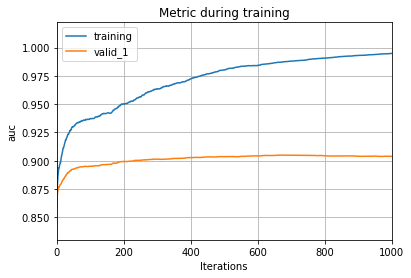

In [117]:
# plot AUC curve against number of iterations
# trained model is overfitted as number of iterations goes beyond 800

ax = lgb.plot_metric(eval_results, metric='auc')
plt.show()

**Predict on validation using trained mdoel**

In [112]:
# predict on x_val using trained light GBM
lgbm_y_pred = lgbm_best1.predict(X_val, pred_contrib=False)

lgbm_y_pred = np.where(lgbm_y_pred > 0.5, 1, 0)

In [113]:
lightGBM_result = confusion_matrix(y_val, lgbm_y_pred)
print("Confusion Matrix:")
print(lightGBM_result)
lightGBM_result1 = classification_report(y_val, lgbm_y_pred)
print("Classification Report:",)
print (lightGBM_result1)
lightGBM_result2 = accuracy_score(y_val, lgbm_y_pred)
print("Accuracy:",lightGBM_result2)

Confusion Matrix:
[[24931   251]
 [ 1629   703]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     25182
           1       0.74      0.30      0.43      2332

    accuracy                           0.93     27514
   macro avg       0.84      0.65      0.70     27514
weighted avg       0.92      0.93      0.92     27514

Accuracy: 0.9316711492331177


## Implement Random Forest

**Hyperparameter tuinng**

In [132]:
# Initialize the set of parameters for exhaustive search and fit 
# max features to be considered at each split
# max depth of the tree (how big to expand)
# min sample leaf = minimum samples at each leaf node

parameters = {'max_features': [1,2, 4, 6, 8, 10, 11,12], 
              'min_samples_leaf': [1, 3, 5, 6, 7], 
              'max_depth': [10, 15, 20, 22, 25, 30, 35]}

# implement randomforest with 100 trees
rforestclassifier = RandomForestClassifier(n_estimators=100, 
                                           random_state=303, n_jobs=-1)

#GridSearch to find the optimal parameters for our example:
rfcv = RandomizedSearchCV(rforestclassifier, parameters, n_jobs=-1, cv=5, verbose=1,
                         random_state=303)
rfcv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=100, n_jobs=-1,
                                                    oob

In [133]:
rfcv.best_params_, rfcv.best_score_

({'min_samples_leaf': 7, 'max_features': 12, 'max_depth': 25},
 0.927662424648359)

In [19]:
# Save rf to file in the current working directory
rf_filename = "rf.pkl"
#with open(rf_filename, 'wb') as rffile:
#    pickle.dump(lgbm_classifier, rffile)
    
# Load from file
with open(rf_filename, 'rb') as rffile:
    pickle_rfmmodel = pickle.load(rffile)

**Get prediction on validation**

In [135]:
rfcv_y_pred = rfcv.predict(X_val)

In [136]:
rfc_result = confusion_matrix(y_val, rfcv_y_pred)
print("Confusion Matrix:")
print(rfc_result)
rfc_result1 = classification_report(y_val, rfcv_y_pred)
print("Classification Report:",)
print (rfc_result1)
rfc_result2 = accuracy_score(y_val, rfcv_y_pred)
print("Accuracy:", rfc_result2)

Confusion Matrix:
[[24958   224]
 [ 1708   624]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     25182
           1       0.74      0.27      0.39      2332

    accuracy                           0.93     27514
   macro avg       0.84      0.63      0.68     27514
weighted avg       0.92      0.93      0.91     27514

Accuracy: 0.9297812022970124


## Implement XGBoost

Instead of numpy arrays or pandas dataFrame, XGBoost uses DMatrices. A DMatrix can contain both the features and the target. If you already have loaded you data into numpy arrays X and y, you can create a DMatrix

In [66]:
X_train2 = X_train.astype('float64')
X_val2   = X_val.astype('float64')
X_test2  = X_test.astype('float64')

In [67]:
xgboost_train = xgb.DMatrix(X_train2,  label=y_train)
xgboost_test  = xgb.DMatrix(X_val2,    label=y_val)
xgboost_newdata = xgb.DMatrix(X_test2, label= y_test)

**Hyperparameter tuning**

In order to tune the other hyperparameters, we will use the cv function from XGBoost. It allows us to run cross-validation on our training dataset and returns logloss score.

We need to pass it:
* num_boost_rounds: It specifies number of boosting trees while training
early_stopping_rounds: This parameter evaluates performance of model for a specified number of rounds, and if the performance does not improve during those many rounds, the training process is stopped.
* max_depth: Depth of a tree is distance between the root and the leaf furthest from the root. Model becomes more complex and tends to overfit as this value increases. Also, memory consumption increases with increase in tree depth.
* min_child_weight: This is used to control the partitioning of tree as it impacts splits within the tree. If a node has sum of instance weight less the minimum specified, then the process will not partition that node.
* Subsample: It is the proportion of the data randomly sampled by XGBoost.By default it is set to 1 meaning that we use all rows.
* colsample_bytree: It is the ratio of the number of columns used in tree construction. By default it is set to 1 meaning that we use all rows.
* eta: It is the learning rate. Higher values make boosting process conservative by shrinking the weights of the features and prevents overfitting.having a lower eta makes our model more robust to overfitting It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step. thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements

We will use logistic loss function to assess the accuracy of predictions, as this is a classification problem

In [35]:
# We will set num_boost_rounds to 100, early_stopping_rounds to 10, and objective to binary:logistic.
# All the other values at this stage are default values.
# We will tune our model by chaning the default values.

params = {'max_depth':6, 
          'min_child_weight':1, 
          'eta':0.3, 
          'subsample':1, 
          'colsample_bytree':1, 
          'objective':'binary:logistic',}

# We will use logloss function to evaluate the model's performance
params['eval_metric'] = "logloss"

xgmodel = xgb.train(params, dtrain = xgboost_train, 
                    num_boost_round = 100, 
                    evals = [(xgboost_test,"Test")], 
                    early_stopping_rounds = 10)

print("Best Logloss: {:.3f} | Rounds: {}".format(xgmodel.best_score,
                                                 xgmodel.best_iteration+1))

[0]	Test-logloss:0.497617
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.390693
[2]	Test-logloss:0.325477
[3]	Test-logloss:0.283189
[4]	Test-logloss:0.255702
[5]	Test-logloss:0.236403
[6]	Test-logloss:0.223274
[7]	Test-logloss:0.214541
[8]	Test-logloss:0.208598
[9]	Test-logloss:0.203509
[10]	Test-logloss:0.200127
[11]	Test-logloss:0.19781
[12]	Test-logloss:0.195951
[13]	Test-logloss:0.194421
[14]	Test-logloss:0.193179
[15]	Test-logloss:0.192417
[16]	Test-logloss:0.1919
[17]	Test-logloss:0.191176
[18]	Test-logloss:0.190645
[19]	Test-logloss:0.19026
[20]	Test-logloss:0.189946
[21]	Test-logloss:0.190031
[22]	Test-logloss:0.189996
[23]	Test-logloss:0.189796
[24]	Test-logloss:0.189354
[25]	Test-logloss:0.189496
[26]	Test-logloss:0.18932
[27]	Test-logloss:0.189355
[28]	Test-logloss:0.189287
[29]	Test-logloss:0.189253
[30]	Test-logloss:0.189099
[31]	Test-logloss:0.189024
[32]	Test-logloss:0.188965
[33]	Test-logloss:0.188872
[34]	Test-logloss:0.1885
[35]	Test-lo

In [43]:
# Parameters: max-depth and min_child_weight (finding its optimal values)

gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(2,4)
                    for min_child_weight in range(5,8)]

In [44]:
logloss_min = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    xg_cvresults = xgb.cv(params, 
                          dtrain = xgboost_train, 
                          num_boost_round = 100,
                          seed = 303, 
                          nfold=10, 
                          metrics = {'logloss'}, 
                          early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    
    print("max_depth: {} | min_child_weight: {} with Logloss: {:.3}\n".format(max_depth,
                                                                              min_child_weight,
                                                                              logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = (max_depth, min_child_weight)

        
print("Best Parameters: max_depth: {} | min_child_weight: {} with Logloss: {:.3f}". \
      format(best_params[0], best_params[1], logloss_min))

max_depth: 2 | min_child_weight: 5 with Logloss: 0.191

max_depth: 2 | min_child_weight: 6 with Logloss: 0.191

max_depth: 2 | min_child_weight: 7 with Logloss: 0.191

max_depth: 3 | min_child_weight: 5 with Logloss: 0.189

max_depth: 3 | min_child_weight: 6 with Logloss: 0.189

max_depth: 3 | min_child_weight: 7 with Logloss: 0.189

Best Parameters: max_depth: 3 | min_child_weight: 7 with Logloss: 0.189


In [46]:
# so far best is max depth 3, min child weight 7
params['max_depth'] = 3
params['min_child_weight'] = 7

In [53]:
# Parameters: subsample and colsample_bytree

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(8,11)]
    for colsample in [i/10. for i in range(5,10)]
]

In [54]:
logloss_min = float("Inf")
best_params = None

for subsample, colsample in (gridsearch_params):
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    xg_cvresults = xgb.cv(params, 
                          dtrain = xgboost_train, 
                          num_boost_round = 100,
                          seed = 303, 
                          nfold=10, 
                          metrics = {'logloss'}, 
                          early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    
    print("subsample: {} | colsample: {} with Logloss: {:.3}\n".format(subsample,
                                                                              colsample,
                                                                              logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = (subsample,colsample)

        
print("Best Parameters: subsample: {} | colsample: {} with Logloss: {:.3f}". \
      format(best_params[0], best_params[1], logloss_min))

max_depth: 0.8 | min_child_weight: 0.5 with Logloss: 0.19

max_depth: 0.8 | min_child_weight: 0.6 with Logloss: 0.19

max_depth: 0.8 | min_child_weight: 0.7 with Logloss: 0.19

max_depth: 0.8 | min_child_weight: 0.8 with Logloss: 0.19

max_depth: 0.8 | min_child_weight: 0.9 with Logloss: 0.19

max_depth: 0.9 | min_child_weight: 0.5 with Logloss: 0.19

max_depth: 0.9 | min_child_weight: 0.6 with Logloss: 0.189

max_depth: 0.9 | min_child_weight: 0.7 with Logloss: 0.19

max_depth: 0.9 | min_child_weight: 0.8 with Logloss: 0.189

max_depth: 0.9 | min_child_weight: 0.9 with Logloss: 0.19

max_depth: 1.0 | min_child_weight: 0.5 with Logloss: 0.189

max_depth: 1.0 | min_child_weight: 0.6 with Logloss: 0.189

max_depth: 1.0 | min_child_weight: 0.7 with Logloss: 0.189

max_depth: 1.0 | min_child_weight: 0.8 with Logloss: 0.19

max_depth: 1.0 | min_child_weight: 0.9 with Logloss: 0.189

Best Parameters: max_depth: 1.0 | min_child_weight: 0.9 with Logloss: 0.189


In [55]:
# so far best subsample is 1.0 and best colsample is 0.9

params['subsample'] = 1.0
params['colsample_bytree'] = 0.9

In [56]:
# Parameter: eta

logloss_min = float("Inf")
best_params = None

for eta in [0.3, 0.2, 0.1, 0.05, 0.01, 0.005]:
    
    params['eta'] = eta
    
    xg_cvresults = xgb.cv(params, dtrain = xgboost_train, 
                          num_boost_round = 100,
                          seed = 303, 
                          nfold=10, 
                          metrics = {'logloss'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-logloss-mean'].min()
    print("eta: {} with Logloss: {:.3}\n".format(eta,logloss_mean))
    
    if logloss_mean < logloss_min:
        logloss_min = logloss_mean
        best_params = eta
        
print("Best Parameter: eta: {} with Logloss: {:.3f}". format(best_params, logloss_min))

eta: 0.3 with Logloss: 0.189

eta: 0.2 with Logloss: 0.19

eta: 0.1 with Logloss: 0.195

eta: 0.05 with Logloss: 0.203

eta: 0.01 with Logloss: 0.332

eta: 0.005 with Logloss: 0.445

Best Parameter: eta: 0.3 with Logloss: 0.189


In [57]:
# Setting the optimum paramters

params = {'colsample_bytree': 0.9,
          'eta': 0.3,
          'eval_metric': 'logloss',
          'max_depth': 3,
          'min_child_weight': 7,
          'objective':'binary:logistic',
          'subsample': 1}

In [64]:
# Finding the optimal number of rounds for the model with new parameters

xgmodel_tuned = xgb.train(params, dtrain = xgboost_train, 
                          num_boost_round=118, 
                          evals=[(xgboost_test,"Test")])


xgmodel_tuned.best_iteration

[0]	Test-logloss:0.500467
[1]	Test-logloss:0.395313
[2]	Test-logloss:0.331291
[3]	Test-logloss:0.290234
[4]	Test-logloss:0.263034
[5]	Test-logloss:0.24473
[6]	Test-logloss:0.232143
[7]	Test-logloss:0.223243
[8]	Test-logloss:0.216963
[9]	Test-logloss:0.212393
[10]	Test-logloss:0.209236
[11]	Test-logloss:0.206118
[12]	Test-logloss:0.203628
[13]	Test-logloss:0.201949
[14]	Test-logloss:0.200297
[15]	Test-logloss:0.199026
[16]	Test-logloss:0.198031
[17]	Test-logloss:0.19724
[18]	Test-logloss:0.196586
[19]	Test-logloss:0.196071
[20]	Test-logloss:0.195701
[21]	Test-logloss:0.195245
[22]	Test-logloss:0.194827
[23]	Test-logloss:0.194258
[24]	Test-logloss:0.193916
[25]	Test-logloss:0.193488
[26]	Test-logloss:0.193081
[27]	Test-logloss:0.192662
[28]	Test-logloss:0.192299
[29]	Test-logloss:0.19186
[30]	Test-logloss:0.191301
[31]	Test-logloss:0.191094
[32]	Test-logloss:0.190605
[33]	Test-logloss:0.190397
[34]	Test-logloss:0.189906
[35]	Test-logloss:0.189828
[36]	Test-logloss:0.189297
[37]	Test-logl

117

In [65]:
# Save rf to file in the current working directory
xgb_filename = "xgb.pkl"
# with open(xgb_filename, 'wb') as xgbfile:
#    pickle.dump(xgmodel_tuned, xgbfile)
    
# Load from file
with open(xgb_filename, 'rb') as xgbfile:
    pickle_xgbmmodel = pickle.load(xgbfile)

**Get prediction on validation**

In [72]:
xgb_y_pred = xgmodel_tuned.predict(xgboost_test)

xgb_y_pred = np.where(xgb_y_pred > 0.5, 1, 0)

In [84]:
xgb_result = confusion_matrix(y_val, xgb_y_pred)
print("Confusion Matrix:")
print(xgb_result)
xgb_result1 = classification_report(y_val, xgb_y_pred)
print("Classification Report:",)
print (xgb_result1)
xgb_result2 = accuracy_score(y_val, xgb_y_pred)
print("Accuracy:", xgb_result2)

Confusion Matrix:
[[24854   328]
 [ 1532   800]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     25182
           1       0.71      0.34      0.46      2332

    accuracy                           0.93     27514
   macro avg       0.83      0.67      0.71     27514
weighted avg       0.92      0.93      0.92     27514

Accuracy: 0.9323980519008505


XGBoost improves the accuracy as compared to LightGBM

# Run trained model on test

Logistic

In [106]:
test_df_cleaned3["hospital_death"] = pickle_logitmodel.predict_proba(X_test)[:,1]

In [107]:
test_df_cleaned3[["encounter_id","hospital_death"]].to_csv("logistic_submission.csv",index=False)
test_df_cleaned3[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.038499
1,5,0.007940
2,7,0.028109
3,8,0.285137
4,10,0.106563


Light GBM

In [ ]:
test_df_cleaned3["hospital_death"] = lgbm_best1.predict(X_test, pred_contrib=False)

In [126]:
test_df_cleaned3[["encounter_id","hospital_death"]].to_csv("lightagbm2_submission.csv",index=False)
test_df_cleaned3[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.038535
1,5,0.017650
2,7,0.015687
3,8,0.159368
4,10,0.736519


Random forest

In [137]:
test_df_cleaned3["hospital_death"] = pickle_rfmmodel.predict_proba(X_test)[:,1]

In [138]:
test_df_cleaned3[["encounter_id","hospital_death"]].to_csv("rf_submission.csv",index=False)
test_df_cleaned3[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.086445
1,5,0.028347
2,7,0.026277
3,8,0.174839
4,10,0.407568


XGboost

In [94]:
test_df_cleaned3["hospital_death"] = pickle_xgbmmodel.predict(xgboost_newdata)

In [95]:
test_df_cleaned3[["encounter_id","hospital_death"]].to_csv("xgb_submission.csv",index=False)
test_df_cleaned3[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.006731
1,5,0.009273
2,7,0.006090
3,8,0.140188
4,10,0.186957
